# Regression with Fourier Features - Part 3

Apply the space-time Fourier embedded net on the original linear oscillator problem.

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy
from collections import OrderedDict

# set random seeds
np.random.seed(10)
torch.manual_seed(10);
torch.set_default_dtype(torch.float64)

import numpy as np    
import matplotlib.pyplot as plt

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output

# import neural nets
from PINN.utils.dnn import *

In [2]:
# modify dataset
full_data_path = "../data/LinearOscillator/OU_Noise_energy.mat"
data = scipy.io.loadmat(full_data_path)
# subsample factor
space_factor = 5
time_factor = 5
new_pmc = (data["v_density"].T)[0:-1:time_factor, 0:-1:space_factor]
new_xgrid = data["xi"][:, 0:-1:space_factor]
new_tgrid = data["tspan"][:, 0:-1:time_factor]
# save new data
new_data_path = "../data/LinearOscillator/OU_Noise_energy_subsample{}.mat".format(int(space_factor*time_factor))
scipy.io.savemat(
    new_data_path, {"pmc": new_pmc, "xgrid": new_xgrid, "tgrid": new_tgrid}
)
# test saved data
new_data_path = "../data/LinearOscillator/OU_Noise_energy_subsample25.mat"
data = scipy.io.loadmat(new_data_path)
print(data["pmc"].shape, data["xgrid"].shape, data["tgrid"].shape)

(1000, 1000) (1, 1000) (1, 1000)


In [3]:
# set random seeds
np.random.seed(10)
torch.manual_seed(10);

data_path = "../data/LinearOscillator/OU_Noise_energy_subsample25.mat"
data = scipy.io.loadmat(data_path)

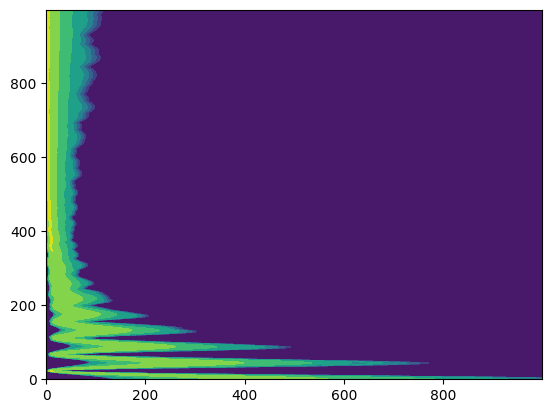

In [4]:
# visualize data
tmp = torch.clamp(torch.log(torch.tensor(data["pmc"])), -30.0)
plt.contourf(tmp.detach().numpy())

In [5]:
X = cartesian_data(torch.tensor(new_tgrid[0].flatten()), torch.tensor(new_xgrid.flatten()))
y = torch.tensor(new_pmc).T.flatten().reshape(-1, 1)
# learn on log scale
log_scale = True
if log_scale:
    y = torch.clamp(torch.log(y), -30.)

In [6]:
# normalize data
normalize = True
if normalize:
    X = X / X.mean(dim=0)
    y = y / y.mean()

In [11]:
# define training function
def train(inputs, outputs, model, optim, scheduler, batch_size, epochs, shuffle=True):
    X, y = inputs, outputs
    nx = X.shape[0]
    num_batches = int(nx/batch_size)
    for i in range(epochs):
        print("============================================================\n")
        print("Epoch = {}\n".format(i+1));
        print("============================================================\n")
        model.train()
        if shuffle:
            tmp = np.random.permutation(nx)
            X, y = X[tmp, :].data.clone(), y[tmp, :].data.clone()
        for idx in range(num_batches):
            if idx % 100 == 0:
                print("| => | Batch {} |\n".format(idx+1))
        # closure definition
            def closure():
                optim.zero_grad()
                start_idx = idx*batch_size
                end_idx = (idx+1)*batch_size
                if idx + 1 == num_batches:
                    # if last batch
                    end_idx = -1
                Xb, yb = X[start_idx:end_idx, :].data.clone(), y[start_idx:end_idx, :].data.clone()

                # require gradients
                Xb.requires_grad = True
                # make a prediction on the batch
                y_pred = model.forward(Xb)
                # compute L^2 loss
                loss = torch.mean((y_pred - yb)**2)
                # backpropagate
                loss.backward()
                if idx % 100 == 0:
                    print("==> Batch {} loss = {}".format(idx, loss.item()))
                return loss
            optim.step(closure=closure)
        if scheduler:
            # step scheduler after epoch if there is one
            scheduler.step()
            print("---------- \n")
            print("++ Learning rate reduced, now at = {}".format(scheduler.get_last_lr()[0]))

In [12]:
# test fourier net in 2d with cartesian product features
# testing Fourier embedded net in 2d (old architecture)
nn_fourier2d_cartesian = FourierProductEmbeddedDNN2d(
    layers_time=[40, 200, 200, 200, 1], 
    layers_space=[40, 200, 200, 200, 1], 
    activation=torch.nn.Tanh, 
    last_layer_activation=None, 
    mt=20, 
    mx=20, 
    freq_stds_t=[1.,2.,10.,20.,50.], 
    freq_stds_x=[1.,2.,10.,20.,50.]
)
optim = torch.optim.Adam(
    nn_fourier2d_cartesian.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(X, y, nn_fourier2d_cartesian, optim, scheduler, 2**12, 50, shuffle=True)


Epoch = 1


| => | Batch 1 |

==> Batch 0 loss = 1.0210247608850942
| => | Batch 101 |

==> Batch 100 loss = 0.01821023525133255
| => | Batch 201 |

==> Batch 200 loss = 0.010383969605894215
---------- 

++ Learning rate reduced, now at = 0.0079992

Epoch = 2


| => | Batch 1 |

==> Batch 0 loss = 0.01039005934285005
| => | Batch 101 |

==> Batch 100 loss = 0.009740629863792732
| => | Batch 201 |

==> Batch 200 loss = 0.008910397369153916
---------- 

++ Learning rate reduced, now at = 0.007998400079999999

Epoch = 3


| => | Batch 1 |

==> Batch 0 loss = 0.0068156878835752156
| => | Batch 101 |

==> Batch 100 loss = 0.0073662494762841875
| => | Batch 201 |

==> Batch 200 loss = 0.006027566427570755
---------- 

++ Learning rate reduced, now at = 0.007997600239991999

Epoch = 4


| => | Batch 1 |

==> Batch 0 loss = 0.005655186046039411
| => | Batch 101 |

==> Batch 100 loss = 0.005823714873065537
| => | Batch 201 |

==> Batch 200 loss = 0.004595590885859549
---------- 

++ Learning r

==> Batch 0 loss = 0.0018419767492365699
| => | Batch 101 |

==> Batch 100 loss = 0.0019240608372172187
| => | Batch 201 |

==> Batch 200 loss = 0.001900433356417333
---------- 

++ Learning rate reduced, now at = 0.00798241846768585

Epoch = 23


| => | Batch 1 |

==> Batch 0 loss = 0.0016893862215517927
| => | Batch 101 |

==> Batch 100 loss = 0.0016962376634897247
| => | Batch 201 |

==> Batch 200 loss = 0.001965608417815464
---------- 

++ Learning rate reduced, now at = 0.007981620225839082

Epoch = 24


| => | Batch 1 |

==> Batch 0 loss = 0.0019526321856094602
| => | Batch 101 |

==> Batch 100 loss = 0.0018447177522086992
| => | Batch 201 |

==> Batch 200 loss = 0.0018892699017446829
---------- 

++ Learning rate reduced, now at = 0.007980822063816497

Epoch = 25


| => | Batch 1 |

==> Batch 0 loss = 0.001809215681422067
| => | Batch 101 |

==> Batch 100 loss = 0.0018490551578076962
| => | Batch 201 |

==> Batch 200 loss = 0.001613066421814126
---------- 

++ Learning rate redu

| => | Batch 101 |

==> Batch 100 loss = 0.0016655485224097563
| => | Batch 201 |

==> Batch 200 loss = 0.0016978443435634325
---------- 

++ Learning rate reduced, now at = 0.007965672141370653

Epoch = 44


| => | Batch 1 |

==> Batch 0 loss = 0.0017648583733127048
| => | Batch 101 |

==> Batch 100 loss = 0.0016713824276747662
| => | Batch 201 |

==> Batch 200 loss = 0.002297185539260146
---------- 

++ Learning rate reduced, now at = 0.007964875574156515

Epoch = 45


| => | Batch 1 |

==> Batch 0 loss = 0.0018643977374515424
| => | Batch 101 |

==> Batch 100 loss = 0.0017640351732654412
| => | Batch 201 |

==> Batch 200 loss = 0.0017841101292624777
---------- 

++ Learning rate reduced, now at = 0.0079640790865991

Epoch = 46


| => | Batch 1 |

==> Batch 0 loss = 0.001706868251878259
| => | Batch 101 |

==> Batch 100 loss = 0.002039534508183117
| => | Batch 201 |

==> Batch 200 loss = 0.0018409947012758758
---------- 

++ Learning rate reduced, now at = 0.007963282678690441

Epoch

In [ ]:
p_pred = nn_fourier2d_cartesian(X).reshape([len(new_xgrid[0]), len(new_tgrid[0])]).detach().numpy().T

In [ ]:
p_exact = data["pmc"]

In [ ]:
plt.contourf(p_pred)

In [ ]:
plt.contourf(p_exact)

In [ ]:
idx = -1
plt.plot(p_pred[idx, :])

In [ ]:
visualize = True
if visualize:
    for i in range(1):
        plt.figure(1);
        plt.plot(new_xgrid.flatten(), p_pred[i, :].flatten(), color="red");
        plt.plot(new_xgrid.flatten(), p_exact[i, :].flatten()/hello, color="blue");
        plt.title(r"$t = {}$".format(i*new_tgrid.flatten()[1]-new_tgrid.flatten()[0]));
        display.clear_output(wait=True);
        display.display(pl.gcf());
        plt.clf();
        time.sleep(0.1);

In [ ]:
p_pred.shape